In [1]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.mixture import GaussianMixture

# 1) Define our four quadrant means and identical isotropic covariances
means = np.array([
    [ 0.5,  0.5],   # Q1: x∈(0,1), y∈(0,1)
    [-0.5,  0.5],   # Q2: x∈(-1,0),y∈(0,1)
    [-0.5, -0.5],   # Q3: x∈(-1,0),y∈(-1,0)
    [ 0.5, -0.5],   # Q4: x∈(0,1), y∈(-1,0)
])
covariance = np.eye(2) * (0.1 ** 2)  # std = 0.2
covariances = np.stack([covariance] * 4, axis=0)

# 2) Build a “fake” GMM by directly assigning its parameters
gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.weights_ = np.ones(4) / 4
gmm.means_ = means
gmm.covariances_ = covariances

# compute precisions_cholesky_ for full covariance
precisions_cholesky = np.zeros_like(covariances)
for i in range(4):
    # precision = inv(covariance)
    P = np.linalg.inv(covariances[i])
    # cholesky of precision
    precisions_cholesky[i] = np.linalg.cholesky(P)
gmm.precisions_cholesky_ = precisions_cholesky

# 3) Oversample from the mixture and carve out exactly 50 per component
#    (we draw 1000 points so that each component will almost surely have ≥50)
samples, labels = gmm.sample(1000)

selected = []
for comp in range(4):
    idx = np.where(labels == comp)[0][:50]
    selected.append(samples[idx])
emb_data = np.vstack(selected)  # shape (200,2)

# 4) Stuff into a torch.nn.Embedding
emb = nn.Embedding(200, 2)
with torch.no_grad():
    emb.weight.copy_(torch.from_numpy(emb_data).float())

print(emb.weight.shape)  # torch.Size([200, 2])


# show plot of the embeddings

torch.Size([200, 2])


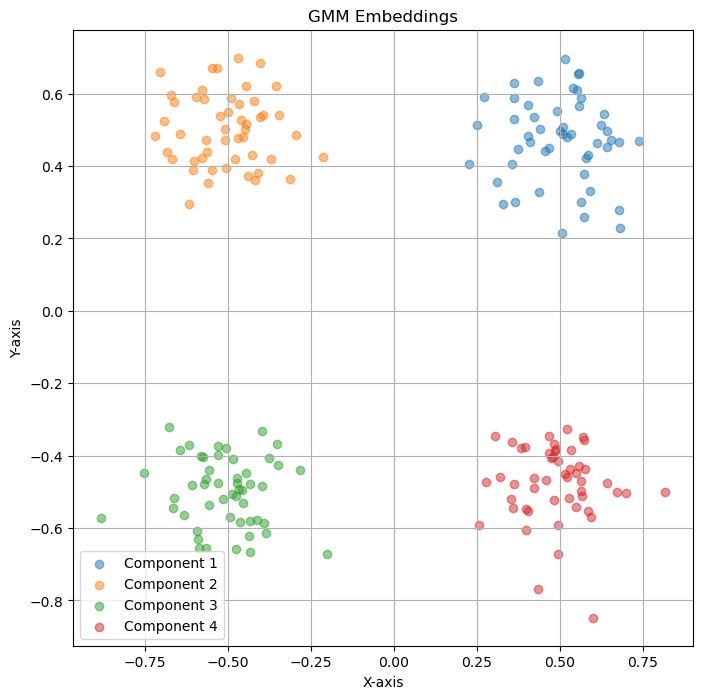

In [2]:
# show plot of the embeddings
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


# embeddings are defined in emb
embeddings = emb.weight.detach()
# labels are the component labels
labels = gmm.predict(embeddings)
# Create a scatter plot
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], label=f'Component {i+1}', alpha=0.5)
plt.title('GMM Embeddings')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()

In [3]:
# create a new set of embeddings in (0,0), (0,-0.5), (-0.5,0), (0,0.5), (0.5,0), (-0.5,-0.5), (-0.5,0.5), (0.5,-0.5), (0.5,0.5)

venue_embeds = np.array([
    [0, 0],
    [0, -0.5],
    [-0.5, 0],
    [0, 0.5],
    [0.5, 0],
    [-0.5, -0.5],
    [-0.5, 0.5],
    [0.5, -0.5],
    [0.5, 0.5]
])
# create a new embedding layer
venue_emb = nn.Embedding(9, 2)
# copy the weights
with torch.no_grad():
    venue_emb.weight.copy_(torch.from_numpy(venue_embeds).float())


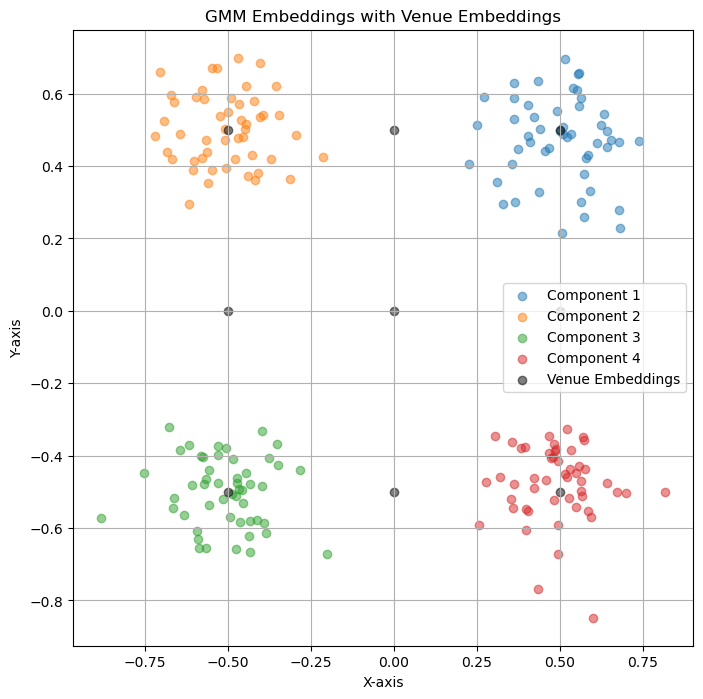

In [4]:
# show plot of the embeddings with venue embeddings in a different color
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.scatter(embeddings[labels == i, 0], embeddings[labels == i, 1], label=f'Component {i+1}', alpha=0.5)
plt.scatter(venue_emb.weight[:, 0].detach().numpy(), venue_emb.weight[:, 1].detach().numpy(), label='Venue Embeddings', color='black', alpha=0.5)
plt.title('GMM Embeddings with Venue Embeddings')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid()
plt.show()


In [12]:
def edge_probability(z_i, z_j, alpha=2):
    """Compute the probability of an edge existing between two embeddings."""
    dist_sq = torch.sum((z_i - z_j) ** 2)  # Squared Euclidean distance (batch-wise)
    # return 1 / (1 + torch.exp(-self.alpha + dist_sq))  # Logistic function, element-wise
    return torch.sigmoid(-dist_sq + alpha)

# create a datamatrix where the first column is the source node, the second column is the target node, and the third column is the label with 1 for positive and 0 for negative
# there should only be a link if the edge probability is greater than 0.75. Start by only using embeddings from the first 4 quadrants

def create_datamatrix(embeddings, threshold=0.5):
    """Create a datamatrix with edges based on the edge probability."""
    num_nodes = embeddings.shape[0]
    datamatrix = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            prob = edge_probability(embeddings[i], embeddings[j])
            if prob > threshold:
                datamatrix.append([i, j, 1])  # Positive edge
            else:
                datamatrix.append([i, j, 0])  # Negative edge
    return np.array(datamatrix)

dm = create_datamatrix(embeddings)


In [11]:
9950*2

19900

In [13]:
len(dm[dm[:, 2] == 1]),len(dm)

(17478, 19900)

In [8]:
import numpy as np
import torch

def create_datamatrix(embeddings, alpha=1.0):
    """For each (i,j), draw label ~ Bernoulli(edge_probability)."""
    embeddings = embeddings.to(torch.float)
    num_nodes = embeddings.size(0)
    datamatrix = []
    
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            p_ij = edge_probability(embeddings[i], embeddings[j], alpha=alpha)
            # sample 0/1
            label = torch.bernoulli(p_ij).item()
            datamatrix.append([i, j, int(label)])
    
    return np.array(datamatrix, dtype=int)

# Example usage
embeddings = emb.weight  # Assuming 'emb' is your embedding layer
dm = create_datamatrix(embeddings)
print(dm.shape)  # Should print the shape of the datamatrix
# Count positive and negative edges
positive_edges = np.sum(dm[:, 2] == 1)
negative_edges = np.sum(dm[:, 2] == 0)
print(f"Positive edges: {positive_edges}, Negative edges: {negative_edges}")


(19900, 3)
Positive edges: 9912, Negative edges: 9988


In [24]:
import torch
import numpy as np
import pandas as pd

def build_link_dataset(paper_embeds: torch.Tensor,
                       venue_embeds: torch.Tensor,
                       edge_prob_fn,
                       num_neg_per_pos=1,
                       alpha=1.0,
                       device='cpu'):
    """
    Returns a DataFrame with columns:
      paper_id, venue_id, paper_vec…, venue_vec…, label
    where label=1 if an edge was sampled between (i,j), else 0.
    """
    P, D = paper_embeds.shape
    V, _ = venue_embeds.shape

    # 1) Sample all positive edges by Bernoulli(p_ij)
    #    (vectorized)
    # compute pairwise distances or whatever your edge_prob_fn uses
    # here as an example: sigmoid(-||p-v||^2 + alpha)
    dists = torch.cdist(paper_embeds, venue_embeds, p=2).pow(2)  # (P, V)
    probs = torch.sigmoid(-dists + alpha)                       # (P, V)
    samp = torch.bernoulli(probs)                               # (P, V)
    pos_idx = samp.nonzero(as_tuple=False)                      # [[i,j],…]

    # 2) For each positive, sample `num_neg_per_pos` negatives
    #    uniformly at random from the zero entries
    neg_candidates = (samp == 0).nonzero(as_tuple=False)
    neg_idx = neg_candidates[
        torch.randperm(len(neg_candidates))[: len(pos_idx) * num_neg_per_pos]
    ]

    # 3) Build rows
    rows = []
    for idx, lab in [(pos_idx, 1), (neg_idx, 0)]:
        for i, j in idx.tolist():
            rows.append({
                'paper_id': i,
                'venue_id': j,
                **{f'p_{k}': float(paper_embeds[i, k]) for k in range(D)},
                **{f'v_{k}': float(venue_embeds[j, k]) for k in range(D)},
                'label': lab
            })

    df = pd.DataFrame(rows)
    # you might shuffle and split afterwards:
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    return df

# Usage example:
# assume `E_p` is your (num_papers×dim) tensor,
#        `E_v` is your (num_venues×dim) tensor,
#        and `alpha` is your distance‐to‐prob parameter
df = build_link_dataset(embeddings, venue_emb.weight, edge_probability, num_neg_per_pos=1, alpha=1.0)

# Peek at the first few examples:
print(df)


      paper_id  venue_id       p_0       p_1  v_0  v_1  label
0          123         4 -0.471581 -0.460861  0.5  0.0      1
1          170         3  0.515584 -0.449370  0.0  0.5      1
2           57         1 -0.577437  0.611257  0.0 -0.5      0
3           97         4 -0.667826  0.419160  0.5  0.0      1
4          167         8  0.486025 -0.387484  0.5  0.5      0
...        ...       ...       ...       ...  ...  ...    ...
1795       171         2  0.361947 -0.477409 -0.5  0.0      1
1796        20         0  0.679477  0.228498  0.0  0.0      0
1797        39         0  0.572271  0.258670  0.0  0.0      0
1798       117         2 -0.484578 -0.409059 -0.5  0.0      1
1799       140         5 -0.433003 -0.666671 -0.5 -0.5      1

[1800 rows x 7 columns]


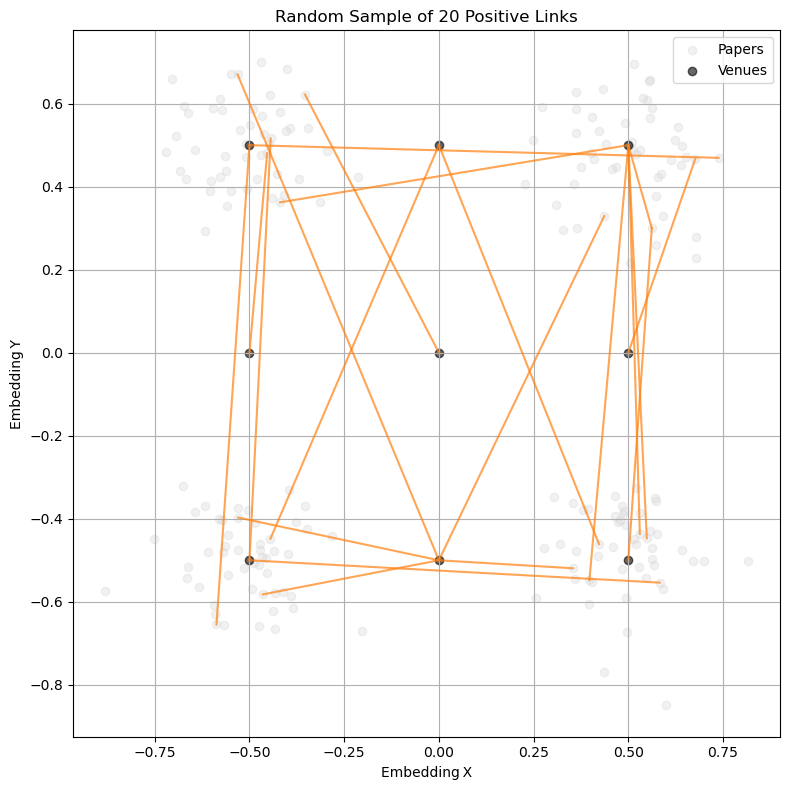

In [26]:
import matplotlib.pyplot as plt

# 1) Sample 20 positive links from your DataFrame
pos_df     = df[df['label'] == 1]
sample_df  = pos_df.sample(n=20, random_state=42)

# 2) Pull out coords
paper_coords = embeddings.detach().cpu().numpy()  # shape (N_papers, 2)
venue_coords = venue_emb.weight.detach().cpu().numpy()  # shape (N_venues, 2)

plt.figure(figsize=(8, 8))

# 3) Base scatter: all papers in light gray
plt.scatter(paper_coords[:, 0],
            paper_coords[:, 1],
            color='lightgray',
            alpha=0.3,
            label='Papers')

# 4) Venue points in black
plt.scatter(venue_coords[:, 0],
            venue_coords[:, 1],
            color='black',
            alpha=0.6,
            label='Venues')

# 5) Draw each sampled positive edge as a line
for _, row in sample_df.iterrows():
    i, j = int(row['paper_id']), int(row['venue_id'])
    px, py = paper_coords[i]
    vx, vy = venue_coords[j]
    plt.plot([px, vx],
             [py, vy],
             color='C1',
             alpha=0.7)

plt.title("Random Sample of 20 Positive Links")
plt.xlabel("Embedding X")
plt.ylabel("Embedding Y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
